In [9]:
from sage.modules.free_module_integer import IntegerLattice

"""
A simple program that given a Heegaard diagram, finds invarinat domains between intersection points and computes their indices (real and ordinary)
This was based on existing code of Cirprian Manolescu
"""

class diagram(object):
    def __init__(self, points, regions, ker, gens = [], tau = {}, sigma = []): 
        """
        points is a list recording intersection points of the diagram. Each point is represented by a list consisting of the four regions which contain it, listed in counter clockwise order.
        regions is a sequential list running over the indices of the regions of the diagram
        Gens is a list of tuples of intersection points which generate CF
        Optionally, tau is a dictionary defining an involution on regions.
        sigma is a list containing 1s and -1s corresponding to the triple index of the intersection points on C
        """
        self.points = points
        self.regions = regions
        self.gens = gens
        self.tau = tau
        self.ker = ker
        self.sigma = sigma

    def tauMatrix(self):
        M = []
        for j in self.regions:
            v = [0 for i in self.regions]
            k = D.tau[j]
            v[k] = 1
            M.append(v)
        return matrix(M)
        
    def tauX(self,j): #takes the j-th intersection point and returns tau(j).
        x = (self.points)[j]
        tx = [self.tau[i] for i in x]
        for p in self.points:
            if set(tx)==set(p):
                return (self.points).index(p)
        
       
    def tauX2(self,x): #takes an element x of points to tau(x) (also represented as an element of points)
        tx = [self.tau[i] for i in x]
        for p in self.points:
            if set(tx)==set(p):
                return p

    def tauGen(self, gen): #given a generator, returns tau(gen)
        return [self.tauX(x) for x in gen]

    def find_fix_set(self):
        fix=[]
        for X in self.gens:
            tauX = [self.tau[p] for p in X]
            tauX.sort()
            #print(x, self.tauGen(x))
            if set(tauX) == set(X):
                fix.append(X)
        return fix
    
    def is_sym(self,Dom): # determines whether a region is symmetric
        bool = True
        for i in range(len(Dom)):
            if Dom[i] != Dom[self.tau[i]]:
                bool = False
        return bool

    
    
    def make_eqn_matrix(self):
    # makes a matrix whose ij entry is the multiplicity of the jth region at the ith intersection point
        B = []
        n = len(self.regions)
        for x in self.points: 
            row = [0 for i in range(0,n)]
            #print(x)
            row[x[0]] += 1
            row[x[1]] += -1
            row[x[2]] += 1
            row[x[3]] += -1
            B.append(row)
        return matrix(B)

    def aug(self, x, y):# for each intersection point adds the equation n1 - n2 + n3 -n4 = ?, 
        #where ? is 0, 1, -1 depending on whether the intersection point is an input/output/neither. 
        n = len(self.regions)
        a = []

        for j in range(len(self.points)):
            #print(x, y, j)
            if j in x and j not in y:
                a.append(1)
                
            elif j in y and j not in x:
                a.append(-1)
            else:
                 a.append(0)
        return a


    def find_kernel(self): # returns the kernel of the matrix B
        B = (self.make_eqn_matrix())
        print(kernel(B.transpose()))

    def is_consistent(self,v): #Given an augmented matrix (A | v) determines whether there's a solution to the corresponding equation
        A = self.make_eqn_matrix()
        B = (A.augment(vector(v))).rref()
        for r in B.rows():
            if r[-1] !=0:
                if sum(abs(r[x]) for x in range(len(r)-1))==0:
                    return False
        return True
    
    def find_bigons(self,x,y): 
    #finds domains. x and y are input and outputs 
        #n = len(self.regions)
        #aug = []
        # for each intersection point adds the equation n1 - n2 + n3 -n4 = ?, where ? is 0, 1, -1 depending on whether the intersection point is an input/output/neither. 
        #for j in range(0,len(self.points)):
        #    #print(x, y, j)
        #    if j in x and j not in y:
        #        aug.append(1)
        #        
        #    elif j in y and j not in x:
        #        aug.append(-1)
        #    else:
        #         aug.append(0)
        
        M = self.make_eqn_matrix()
        
        A = self.aug(x,y)
        if self.is_consistent(A):
            #print(M)
            v = M.solve_right(vector(A))
            if is_integral(v):
                while not is_positive(v):
                    v = v+vector(self.ker)
                return v
            else:
                return []
        else:
            return []

    def find_sym_bigons(self,x,y): # finds bigons between x and y and throws out non-symmetric domains.
        #F = fixset
        #print(B)
        #if x not in F:
            #print(x)
        #    print('x is not in the fixed set')
        #if y not in F:
            #print(y)
        #    print('y is not in the fixed set')
        v = self.find_bigons(x,y)
        if self.is_sym(v):
            return v
        else:
            return []
            
    def euler_region(self,R): # given a region returns the Euler measure. Every region is a polygon with acute angles, so e=1-#corners/4
        corners = 0
        for x in self.points:
            for i in x:
                if i == R:
                    corners += 1
        return 1 - corners/4
    
    def euler(self,D): # Given a domain, computes the Euler measure. The Euler measure is additive, so we just add up the regions
        sum = 0
        for i in range(len(D)):
            sum += D[i]*self.euler_region(i)
        return sum

    def n_p_region(self,p,R): # given an intersection point p, computes the average multiplicity of R at p
        sum = 0
        for i in p:
            if i == R:
                sum+=1
        return sum/4
    
    def n_p(self,p,D): # given a domain (linear combo of regions) returns the averge multiplicity at p
        sum = 0
        for i in p:
            sum += D[i]
        return sum/4

    def ind(self,D, X, Y):
        x = [self.points[p] for p in X]
        y = [self.points[p] for p in Y]
        #print(x, y)
        e = self.euler(D)
        nx = 0
        ny = 0
        for p in x:
            nx += self.n_p(p, D)
        for p in y:
            ny += self.n_p(p, D)
        return e + nx + ny

    def sigma_x(self, x): # given a generator, returns sigma(x)
        sum = 0
        for i in x:
            sum+= self.sigma[i]
        return sum

    def indR(self, dom, x, y):
        I = self.ind(dom, x, y)
        return (I + (self.sigma_x(x) - self.sigma_x(y))/2)/2

    def find_spinC(self,graph = False): #returns the number of SpinC structures
        G = Graph()
        for i in range(len(self.gens)):
            G.add_vertex(i)
        for i in range(len(self.gens)):
            for j in range(len(self.gens)):
                if len(self.find_bigons(self.gens[i],self.gens[j]))>0:
                    if i !=j:
                        G.add_edge(i,j)
        num = G.connected_components_number()
        for x in G.connected_components():
            if len(x)%2==0:
                num = num -1
        if graph == False:
            return num #G.connected_components_number()
        else:
            return G

# Some helper functions


def is_integral(v): #given a list v, checks if all entries are integral.
    #print(v)
    for i in v:
        if float(i)%1 !=0:
            return False
    return True

def is_positive(v): #given a list v, checks if all entries are positive.
    pos = True
    zero=True
    for x in v:
        if x <0:
            pos = False
        if x != 0:
            zero = False
    if zero == True: 
        return False
    else:
        return pos

    

    

In [7]:
# heegaard diagram for 9_46

P = [
    [3,10,1,2],[5,11,3,4],[6,0,6,5],
    [5,7,5,6],[8,1,8,7],
    [1,8,1,0],[9,11,8,4],[6,10,9,2],
    [4,3,2,9],[7,5,4,8],[2,1,0,6],
    [11,9,10,3],[11,5,7,8],[0,1,10,6]
]
R=[i for i in range(0,12)]

sigma = [1,1,-1,
         -1,-1,
         -1,1,1,
         0,0,0,
         0,0,0
        ]

CP = [0,2,3,6]
CR = [9,10,11]
BR = [1,4,5,7]
BP = [8,12,13]

#gens = [[i,j] for i in CP for j in BR] + [[i,j] for i in CR for j in BP] 

gens = [[0, 1],
 [0, 4],
 [0, 5],
 [0, 7],
 [2, 1],
 [2, 4],
 [2, 5],
 [2, 7],
 [3, 1],
 [3, 4],
 [3, 5],
 [3, 7],
 [6, 1],
 [6, 4],
 [6, 5],
 [6, 7],
 [9, 12],
 [10, 13],
 [11, 8]
      ]


tau = {}
for i in R:
    if i == 2:
        tau[i] = 10
    elif i == 10:
        tau[i] = 2
    elif i == 4:
        tau[i] = 11
    elif i == 11:
        tau[i] = 4
    else:
        tau[i] = i

D = diagram(P,R,[1,1,1,1,1,1,1,1,1,1,1,1],gens,tau, sigma)

for x in gens:
    for y in gens:
        if x != y:
            dom = D.find_sym_bigons(x,y)
            if len(dom)>0:
                if dom[1] == 0:
                    if D.indR(dom,x, y) ==1:
                        print(x,y)
                        print(dom)
                


[0, 1] [11, 8]
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
[2, 7] [3, 5]
(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)
[3, 1] [0, 5]
(0, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1)
[3, 1] [2, 4]
(0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0)
[6, 1] [2, 5]
(0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0)
[6, 4] [3, 5]
(0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0)
[6, 7] [11, 8]
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)
[9, 12] [3, 4]
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)
[10, 13] [2, 5]
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


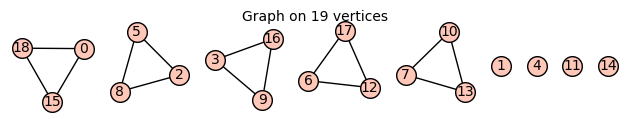

In [10]:
D.find_spinC(True)